In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
from pathlib import Path

In [2]:
# Path containing dataset
ROOT_DIR = Path(r"data")

In [3]:
# Example of the records we want to classify as 1
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
# Example of the records we want to classify as 0
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [4]:
# Sample rate which is enough to catch whole spectrum of appearing sounds
SR = 22_050
# 3 sec chunk
CHUNK_DURATION = 3*SR

In [5]:
def load_wav_22k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 22_050Hz of sampling which provides correct interpretation of 11_025Hz sounds frequency.
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=SR)
    return wav

In [6]:
wav = load_wav_22k_mono(CAPUCHIN_FILE)
nwav = load_wav_22k_mono(NOT_CAPUCHIN_FILE)
wav

<tf.Tensor: shape=(66150,), dtype=float32, numpy=
array([ 1.2882366e-06, -3.6249060e-06,  3.6814472e-06, ...,
       -2.6663244e-02, -3.7260264e-02,  2.1729119e-02], dtype=float32)>

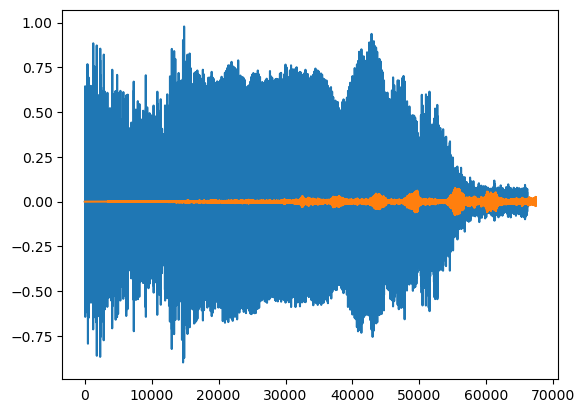

In [7]:
plt.plot(wav)
plt.plot(nwav)

### 3.1 Create tensflow Datasets

In [8]:
# Records' labels to paths we want to classify as 1
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
# Records' labels to paths we want to classify as 0
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

In [9]:
# contains paths to data as generator
pos = tf.data.Dataset.list_files(POS+r'\*.wav')
neg = tf.data.Dataset.list_files(NEG+r'\*.wav')

### 3.2 Add labels and combine positive and negetaive samples

In [10]:
# set 0 or 1 to data path depends on it is capuchin or not
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)
# data.as_numpy_iterator().next()

### 3.3 Checking how long records last and what is the size of

In [14]:
lengths = []
for file in os.listdir(POS):
    tensor_wave = load_wav_22k_mono(file)
    lengths.append(len(tensor_wave))
lengths

[]

In [ ]:
tf.math.reduce_mean(lengths)

In [ ]:
tf.math.reduce_max(lengths)

In [ ]:
tf.math.reduce_min(lengths)

### 5.1 Build preprocessing function

In [ ]:
def process_record_to_dbscale_mel_spectrogram(wav):
    # Process fading edges of record which helps with avoiding aliasing
    fade = tfio.audio.fade(wav, fade_in=1000, fade_out=2000, mode="logarithmic")
    spectrogram = tfio.audio.spectrogram(fade, nfft=512, window=512, stride=256)
    # There are kept only frequencies in which signal power spectrum of capuchine bird is contained
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=SR, mels=128, fmin=256, fmax=2048)
    dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)
    # it's use to make appropriate format for further processing
    # now it's 3D tensor like image width, length and rgb format
    dbscale_mel_spectrogram = tf.expand_dims(dbscale_mel_spectrogram, axis=2)
    
    return dbscale_mel_spectrogram

In [ ]:
def pad_record(wav):
    wav = wav[:CHUNK_DURATION] 
    # Pad records in order to keep thier sizes equal
    zero_padding = tf.zeros([CHUNK_DURATION] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    
    return wav

In [ ]:
def preprocess(file_path, label):
    wav = load_wav_22k_mono(file_path)
    padded_wav = pad_record(wav)
    dbscale_mel_spectrogram = process_record_to_dbscale_mel_spectrogram(padded_wav)
    
    return dbscale_mel_spectrogram, label

In [ ]:
x = preprocess(r"data\Parsed_Capuchinbird_Clips\XC3776-2.wav", 2)
print(x)

(<tf.Tensor: shape=(259, 128, 1), dtype=float32, numpy=
array([[[-36.382927],
        [-49.027626],
        [-49.027626],
        ...,
        [-20.391157],
        [-43.454285],
        [-20.478382]],

       [[-25.83843 ],
        [-49.027626],
        [-49.027626],
        ...,
        [-25.163403],
        [-38.24878 ],
        [-15.272875]],

       [[-31.476786],
        [-49.027626],
        [-49.027626],
        ...,
        [-13.973317],
        [-48.08854 ],
        [-25.112637]],

       ...,

       [[-32.861046],
        [-49.027626],
        [-49.027626],
        ...,
        [-30.400942],
        [-49.027626],
        [-26.233807]],

       [[-49.027626],
        [-49.027626],
        [-49.027626],
        ...,
        [-40.790756],
        [-49.027626],
        [-46.0175  ]],

       [[-49.027626],
        [-49.027626],
        [-49.027626],
        ...,
        [-49.027626],
        [-49.027626],
        [-49.027626]]], dtype=float32)>, 2)


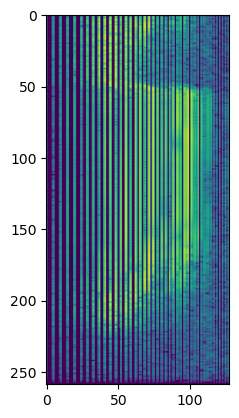

In [ ]:
fade = tfio.audio.fade(wav, fade_in=1000, fade_out=2000, mode="logarithmic")
spectrogram = tfio.audio.spectrogram(fade, nfft=512, window=512, stride=256)
mel_spectrogram = tfio.audio.melscale(spectrogram, rate=SR, mels=128, fmin=256, fmax=2048)
dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)

plt.figure()
plt.imshow(dbscale_mel_spectrogram.numpy())


### 6. Create training and testing partitions   
#### 6.1 Create a Tensorflow Data Pipeline


In [ ]:
data = data.map(preprocess)
# cache data to improve learning speed 
data = data.cache()
data = data.shuffle(buffer_size=1000)
# batching data - updating weights occur after computing back propagation at one batch 
data = data.batch(16)
# This allows later elements to be prepared while the current element is being processed
# Eliminates cpu bottlenecking
data = data.prefetch(8)

In [ ]:
len(data)

51

In [ ]:
# Split into train and test data sets
train = data.take(36)
test = data.skip(36).take(15)

In [ ]:
samples, labels = train.as_numpy_iterator().next()
samples, labels

(array([[[[-54.96943   ],
          [-79.90302   ],
          [-79.90302   ],
          ...,
          [-47.482704  ],
          [-69.36494   ],
          [-46.38903   ]],
 
         [[-46.826557  ],
          [-79.90302   ],
          [-79.90302   ],
          ...,
          [-42.740597  ],
          [-79.90302   ],
          [-61.74552   ]],
 
         [[-45.74926   ],
          [-79.90302   ],
          [-79.90302   ],
          ...,
          [-34.38776   ],
          [-65.95409   ],
          [-42.978188  ]],
 
         ...,
 
         [[-48.58506   ],
          [-79.90302   ],
          [-79.90302   ],
          ...,
          [-46.949825  ],
          [-74.26999   ],
          [-51.29409   ]],
 
         [[-79.90302   ],
          [-79.90302   ],
          [-79.90302   ],
          ...,
          [-55.503967  ],
          [-79.90302   ],
          [-59.348854  ]],
 
         [[-79.90302   ],
          [-79.90302   ],
          [-79.90302   ],
          ...,
          [-79.90302 

#### 7. Build Deep Learnign Dependencies

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, BatchNormalization, MaxPool2D, Dropout

In [ ]:
model=Sequential([
    Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(259, 128, 1)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3)),
    Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Flatten(),
    Dense(1024,activation='relu'),
    Dropout(0.5),
    Dense(1024,activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid')
])

In [ ]:
model.compile("Adam", loss="BinaryCrossentropy", metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 63, 30, 128)       15616     
                                                                 
 batch_normalization (BatchN  (None, 63, 30, 128)      512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 15, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 15, 256)       819456    
                                                                 
 batch_normalization_1 (Batc  (None, 31, 15, 256)      1024      
 hNormalization)                                                 
                                                        

                                                                 
 batch_normalization_4 (Batc  (None, 10, 5, 256)       1024      
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 2, 256)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 1024)              2622464   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1

In [ ]:
hist = model.fit(train, epochs=36, validation_data=test)

Epoch 1/36


36/36 [==============================] - 13s 276ms/step - loss: 0.8604 - recall: 0.7212 - precision: 0.7391 - val_loss: 0.8227 - val_recall: 0.8732 - val_precision: 0.8378
Epoch 2/36
36/36 [==============================] - 9s 243ms/step - loss: 0.3705 - recall: 0.8424 - precision: 0.8476 - val_loss: 5.0492 - val_recall: 0.2453 - val_precision: 0.9286
Epoch 3/36
36/36 [==============================] - 9s 257ms/step - loss: 0.4966 - recall: 0.8750 - precision: 0.8974 - val_loss: 4.4323 - val_recall: 0.9861 - val_precision: 0.3817
Epoch 4/36
36/36 [==============================] - 9s 244ms/step - loss: 0.2583 - recall: 0.9128 - precision: 0.8889 - val_loss: 0.1791 - val_recall: 0.9655 - val_precision: 0.9180
Epoch 5/36
36/36 [==============================] - 9s 248ms/step - loss: 0.2648 - recall: 0.9295 - precision: 0.9477 - val_loss: 1.1842 - val_recall: 0.8485 - val_precision: 0.9492
Epoch 6/36
36/36 [==============================] - 9s 263ms/step - loss: 0.4749 - recall: 0.8725 - 

In [ ]:
model.history.history.keys()

dict_keys(['loss', 'recall', 'precision', 'val_loss', 'val_recall', 'val_precision'])

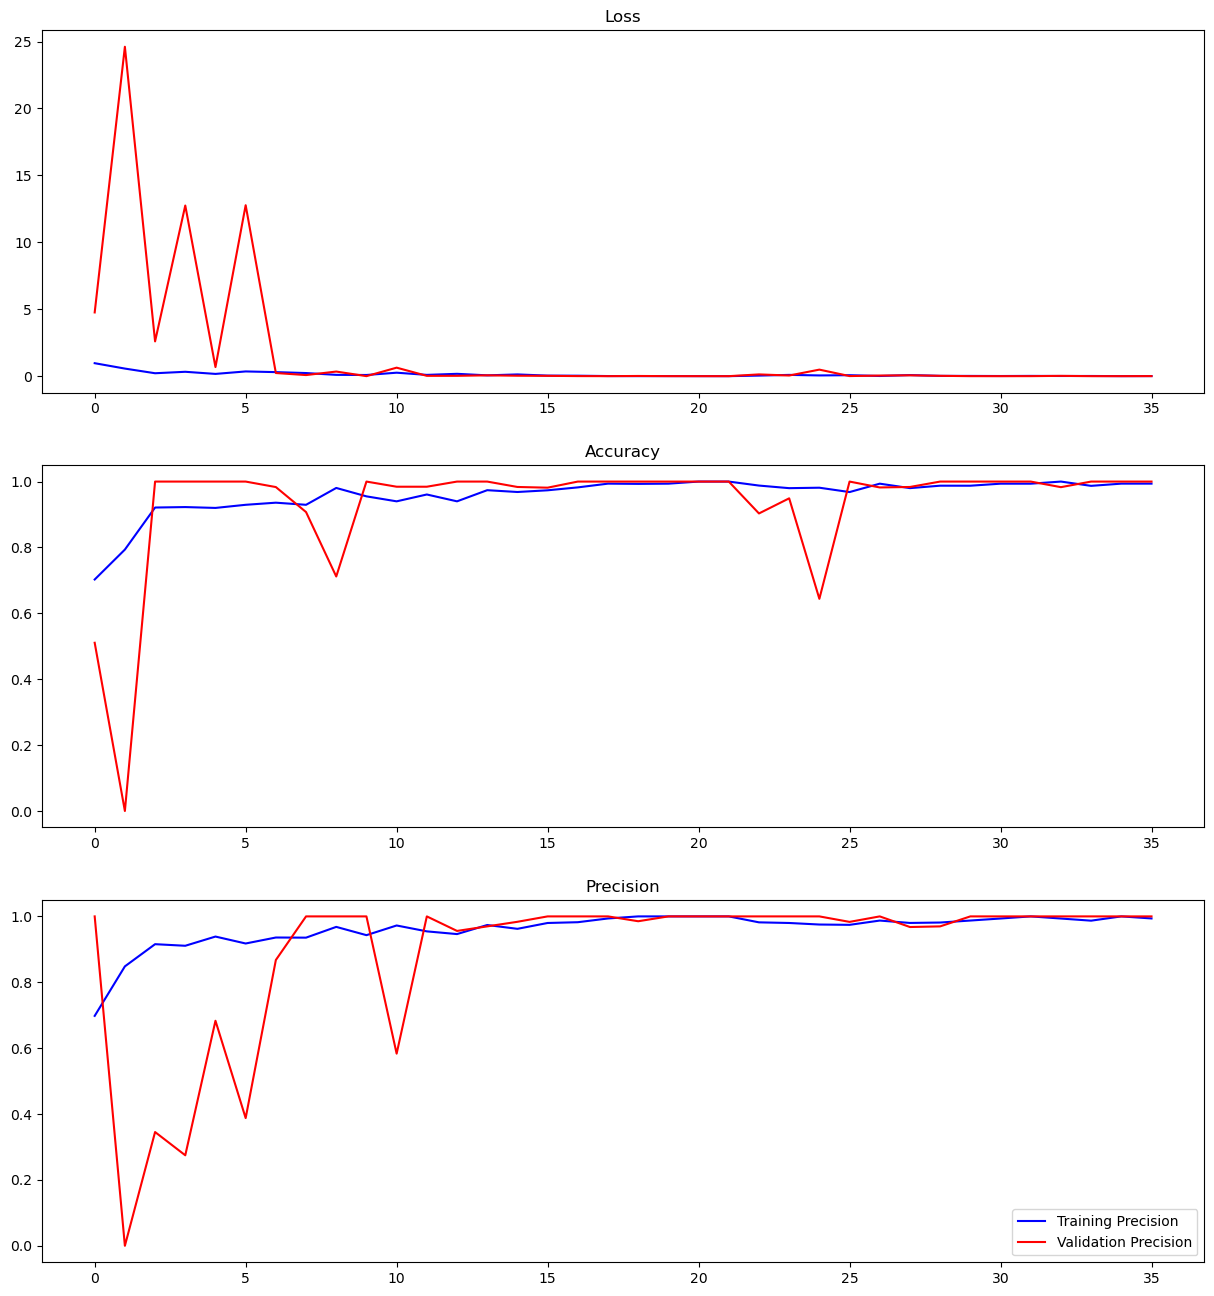

In [ ]:
f,ax=plt.subplots(3,1,figsize=(15,16)) 

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')
ax[0].title.set_text('Loss')

ax[1].plot(model.history.history['recall'],color='b',label='Training Recall')
ax[1].plot(model.history.history['val_recall'],color='r',label='Validation Recall')
ax[1].title.set_text('Accuracy')

ax[2].plot(model.history.history['precision'],color='b',label='Training Precision')
ax[2].plot(model.history.history['val_precision'],color='r',label='Validation Precision')
ax[2].title.set_text('Precision')

plt.legend()

In [ ]:
hist.history

{'loss': [0.0010136859491467476,
  0.013406714424490929,
  0.020245136693120003,
  0.0298786461353302,
  0.01125410571694374,
  0.029328299686312675,
  0.0830877274274826,
  0.07496770471334457,
  0.007480714935809374,
  0.018398752436041832,
  0.060412533581256866,
  0.07212883979082108,
  0.0339556485414505,
  0.04043563827872276,
  0.003204119624570012,
  0.025394966825842857,
  0.0513891875743866,
  0.02818867564201355,
  0.07858011871576309,
  0.022476129233837128,
  0.026386722922325134,
  0.028813442215323448,
  0.01286586094647646,
  0.014938963577151299,
  0.040473803877830505,
  0.008223125711083412,
  0.0046248179860413074,
  0.11165358126163483,
  0.021074242889881134,
  0.012178206816315651,
  0.05136636272072792,
  0.001105152303352952,
  0.007749652490019798,
  0.0038235438987612724,
  0.00027176842559129,
  3.310688043711707e-05],
 'recall_2': [1.0,
  0.9927007555961609,
  0.9868420958518982,
  0.9865771532058716,
  0.9931507110595703,
  0.9871794581413269,
  0.98051947

### 8. Make a prediction on a single clip

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()
print(X_test.shape, y_test.shape)

(16, 259, 128, 1) (16,)


In [ ]:
yhat = model.predict(X_test)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]
print(yhat, y_test)

1/1 [==============================] - 1s 531ms/step
[1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# Func takes file_path, converts mp3 to audio_data and ceases frequency to 22_050
def load_mp3_22k_mono(filename):
    # byte encoded string like with serial protocol
    res = tfio.audio.AudioIOTensor(filename)
    # convert to tensor and combine channels
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # resample to 22_050 Hz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=SR)
    return wav

In [ ]:
def preprocess_mp3(sample, _):
    wav = sample[0]
    padded_wav = pad_record(wav)
    dbscale_mel_spectrogram = process_record_to_dbscale_mel_spectrogram(padded_wav)
    return dbscale_mel_spectrogram

In [ ]:
mp3 = os.path.join("data", "Forest Recordings", "recording_00.mp3")
# res = tfio.audio.AudioIOTensor(mp3)
# tensor = res.to_tensor()
# tensor

In [ ]:
wave = load_mp3_22k_mono(mp3)
wave

<tf.Tensor: shape=(3969918,), dtype=float32, numpy=
array([-1.08226293e-11,  2.00325104e-11, -2.67326786e-11, ...,
       -6.69778325e-03, -1.00784665e-02, -5.57146687e-03], dtype=float32)>

In [ ]:
# slice clip into fragments which have the same length as traning model clips (3 sec)
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wave, wave, sequence_length=CHUNK_DURATION, sequence_stride=CHUNK_DURATION, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [ ]:
yhat = model.predict(audio_slices)
# I think it could be caused by ill-trained model
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]
print(yhat)

1/1 [==============================] - 1s 1s/step
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
from itertools import groupby

In [ ]:
# that group results in zeros and ones
yhat = [key for key, group in groupby(yhat)]
for key, group in groupby(yhat):
    print(key, group)
calls = tf.math.reduce_sum(yhat).numpy()
calls

0 <itertools._grouper object at 0x000002C0466EE890>
1 <itertools._grouper object at 0x000002C0466931F0>
0 <itertools._grouper object at 0x000002C046720550>
1 <itertools._grouper object at 0x000002C0466931F0>
0 <itertools._grouper object at 0x000002C046720550>
1 <itertools._grouper object at 0x000002C0466931F0>
0 <itertools._grouper object at 0x000002C046720550>
1 <itertools._grouper object at 0x000002C0466931F0>
0 <itertools._grouper object at 0x000002C046720550>
1 <itertools._grouper object at 0x000002C0466931F0>
0 <itertools._grouper object at 0x000002C046720550>


5

In [ ]:
results = dict()
for file in os.listdir(os.path.join("data", "Forest Recordings")):
    FILEPATH = os.path.join("data", "Forest Recordings", file)

    wave = load_mp3_22k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wave, wave, sequence_length=CHUNK_DURATION, sequence_stride=CHUNK_DURATION, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)

    yhat = model.predict(audio_slices)

    results[file] = yhat

In [ ]:
results

{'recording_00.mp3': array([[6.5689871e-09],
        [1.7654840e-10],
        [1.4308353e-09],
        [8.5565887e-23],
        [1.0000000e+00],
        [1.1968996e-20],
        [2.1513906e-09],
        [6.0849388e-11],
        [2.5750151e-09],
        [1.0105738e-09],
        [1.7204076e-10],
        [1.2582553e-09],
        [1.4931780e-09],
        [2.3595950e-30],
        [9.9999923e-01],
        [1.9153697e-10],
        [2.1416320e-11],
        [8.5979862e-10],
        [6.8962315e-11],
        [1.8033500e-10],
        [8.1031537e-10],
        [2.1773818e-09],
        [2.3684896e-09],
        [9.5027946e-13],
        [1.0000000e+00],
        [2.9848988e-17],
        [2.6794003e-09],
        [1.0882055e-11],
        [5.8247531e-09],
        [2.5118421e-08],
        [2.2695135e-10],
        [9.0828078e-10],
        [5.6471295e-12],
        [1.1109262e-15],
        [1.6475497e-10],
        [2.1673450e-05],
        [1.0000000e+00],
        [2.7465706e-15],
        [1.3964803e-09],
     

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_00.mp3': [0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_03.mp3': [0,
  0,
  0,
  

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, _ in groupby(scores)]).numpy()
postprocessed

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 1,
 'recording_05.mp3': 0,
 'recording_06.mp3': 3,
 'recording_07.mp3': 2,
 'recording_08.mp3': 24,
 'recording_09.mp3': 0,
 'recording_10.mp3': 3,
 'recording_11.mp3': 2,
 'recording_12.mp3': 0,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 1,
 'recording_16.mp3': 5,
 'recording_17.mp3': 3,
 'recording_18.mp3': 0,
 'recording_19.mp3': 0,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 5,
 'recording_24.mp3': 0,
 'recording_25.mp3': 0,
 'recording_26.mp3': 2,
 'recording_27.mp3': 0,
 'recording_28.mp3': 4,
 'recording_29.mp3': 0,
 'recording_30.mp3': 1,
 'recording_31.mp3': 1,
 'recording_32.mp3': 1,
 'recording_33.mp3': 0,
 'recording_34.mp3': 4,
 'recording_35.mp3': 0,
 'recording_36.mp3': 0,
 'recording_37.mp3': 3,
 'recording_38.mp3': 1,
 'recording_39.mp3': 2,
 'recording_40.mp3': 1,
 'recording_41.

In [ ]:
model.save_weights('./saved_models/weights')

# 11. Export Results

In [ ]:
import csv

In [ ]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])